<a href="https://colab.research.google.com/github/gravityrahul/DeepLearning/blob/master/03_Robust%2C_Deep_and_Inductive_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pip install picklable_itertools
!pip install fuel
!pip install foolbox
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
PROJECT_DIR = "/content/gdrive/My Drive/one_class_neural_networks/"
import sys,os
import numpy as np
sys.path.append(PROJECT_DIR)

TensorFlow 1.x selected.
1.15.2
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
  Created wheel for picklable-itertools: filename=picklable_itertools-0.1.1-cp36-none-any.whl size=15591 sha256=cdcfa19135fc86b8de918b79fc9c26bf9a91067f351ba9f63a8a8fef774976dc
  Stored in directory: /root/.cache/pip/wheels/36/dd/e2/ec30ef7c475e1d9fb966735984ba05f8710c67d7de5358c326
Successfully built picklable-itertools
     |████████████████████████████████| 194kB 6.9MB/s 
  Created wheel for fuel: filename=fuel-0.2.0-cp36-cp

# From Autoencoder to Robust Autoencoder


# 

## Sydney Harbour Bridge : Autoencoder based on  FFT Features 

Automatically created module for IPython interactive environment
/content/gdrive/My Drive/one_class_neural_networks//data/27-06-2019/SHM/SHM_2_joints_2_sensors_Aug12_Oct12_fft.csv


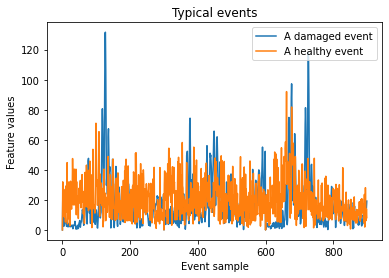

Running trial 1 ............
Train data: (n,d) =  (1000, 900)
Test data: (n,d) =  (10867, 900)
Test data: healthy = 3983, damage = 6884
OCSVM results:
F1 score = 0.9754045768874314
G-mean = 0.9589656935351187
AUC = 0.9950341318412667
Confusion matrix =
 [[6841   43]
 [ 302 3681]]
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 900)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               90100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_7 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_8 (Dense)              (None, 900)  

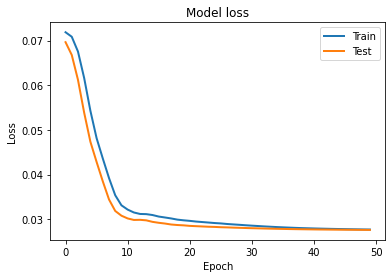

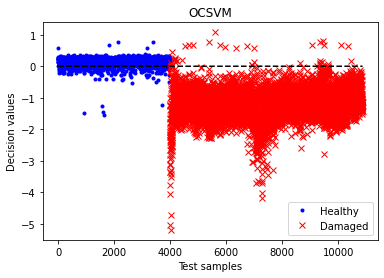

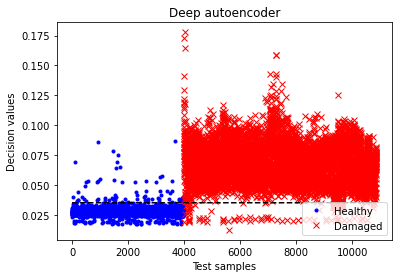


---------------------------------------
OCSVM results (nTrials = 1):
Average F1 score = 0.9754045768874314
Average g-mean = 0.9589656935351187
Average AUC = 0.9950341318412667
A confusion matrix =
 [[6841   43]
 [ 302 3681]]

Deep auto-encoder results (nTrials = 1):
Average F1 score = 0.9868957483983692
Average g-mean = 0.9830115075065542
Average AUC = 0.9888035919070927
A confusion matrix =
 [[6778  106]
 [  74 3909]]
aaa


In [ ]:
print(__doc__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

# import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard, EarlyStopping
from keras import regularizers


def create_model(input_dim, encoding_dim, hidden_dim):
	# create model
    autoencoder = Sequential()
    autoencoder.add(encoding_dim, activation='relu', input_shape=input_dim)
    autoencoder.add(hidden_dim, activation='relu')
    autoencoder.add(encoding_dim, activation='relu')
    autoencoder.add(input_dim, activation='sigmoid')

    autoencoder.compile(loss='mean_squared_error', optimizer='adam')

	# return autoencoder


def tuning_model(X):
    # tuning deep auto encoder parameter
    # X: healthy data

	# parameter ranges
    nb_epoch_list = [50, 100, 200, 300]
    batch_size_list = [32, 64, 128, 256, 512]
    input_dim = X.shape[1]  # num of features
    encoding_dim = 100  # int(input_dim / 2)
    hidden_dim = 10  # int(encoding_dim / 2)
    nStd = 3

    input_layer = Input(shape=(input_dim,))
    # encoder = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    encoder = Dense(hidden_dim, activation='relu')(encoder)

    # encoder = Dense(int(hidden_dim / 2), activation='relu')(encoder)
    # decoder = Dense(hidden_dim, activation='relu')(encoder)

    decoder = Dense(encoding_dim, activation='relu')(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.summary()

    autoencoder.compile(loss='mean_squared_error', optimizer='adam')

    # # early stopping
    EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

    best_mse = sys.maxsize
    for i in range(len(nb_epoch_list)):
        for j in range(len(batch_size_list)):
            history = autoencoder.fit(X, X,
                                      epochs=nb_epoch_list[i],
                                      batch_size=batch_size_list[j],
                                      shuffle=True,
                                      validation_split=0.2,
                                      # validation_data=(X_test, X_test),
                                      verbose=0).history

            # X_predicted = autoencoder.predict(X)
            # mse = np.mean(np.mean(np.power(X - X_predicted, 2), axis=1))
            mse = history['val_loss'][-1]
            if mse < best_mse:
                best_mse = mse
                best_epoch = nb_epoch_list[i]
                best_batch_size = batch_size_list[j]

    return best_epoch, best_batch_size

# #############################################################################
# Main
positive_label = -1
nStd = 3 # for outlier threshold of AE
nu = 0.05
nTrials = 1

fs_svm = np.zeros(nTrials)
gm_svm = np.zeros(nTrials)
auc_svm = np.zeros(nTrials)
fs_ae = np.zeros(nTrials)
gm_ae = np.zeros(nTrials)
auc_ae = np.zeros(nTrials)

# # SHB J44 sampled data
# file_name = ('../../Matlab/Datasets/SHM/SHM_2_joints_2_sensors_Aug12_Oct12.csv')
#file_name = ('/Users/cha764/Documents/projects/SHM/27-06-2019/SHM/SHM_2_joints_2_sensors_Aug12_Oct12_fft.csv')

file_name = (PROJECT_DIR + '/data/27-06-2019/SHM/SHM_2_joints_2_sensors_Aug12_Oct12_fft.csv')
#file_name = (PROJECT_DIR + '/data/27-06-2019/SHM/SHM_2_joints_2_sensors_Aug12_Oct12_raw.csv')
nTrains = 1000

# file_name = ('../../Matlab/Datasets/SHM/SHM_6_joints_6_sensors_V1_Aug12_Oct12_sampled.csv')
# nTrains = 1000

# # UTS specimen 2 data with 4 level of damage
# file_name = ('../../Matlab/Datasets/SHM/specimen2_loc2_node2.csv')
# nTrains = 150

print(file_name)

data_df = pd.read_csv(file_name, header = None, index_col= False)
X = data_df.iloc[:,1:].values
y = data_df.iloc[:,0].values
if sum(y==0) > 0:
    y[y==1] = -1
    y[y==0] = 1

index_healthy = np.where(y == 1)[0]
index_damage = np.where(y == -1)[0]

plt.subplots()
plt.plot(X[index_damage[random.randint(0,len(index_damage))]], label='A damaged event')
plt.plot(X[index_healthy[random.randint(0,len(index_healthy))]], label='A healthy event')
plt.legend(loc='upper right')
plt.title('Typical events')
plt.ylabel('Feature values')
plt.xlabel('Event sample')
plt.show(block=False)

for i in range(nTrials):

    print('Running trial {} ............'.format(i+1))

    # train, test split
    # index = np.arange(len(index_healthy))
    index = np.random.permutation(len(index_healthy))
    index_train = index_healthy[index[:nTrains]]
    index_test = np.concatenate((index_healthy[index[nTrains:]], index_damage))
    X_train = X[index_train,:]
    y_train = y[index_train]
    X_test = X[index_test,:]
    y_test = y[index_test]

    # best_epoch, best_batch_size = tuning_model(X_train)

    if i==0:
        print('Train data: (n,d) = ', X_train.shape)
        print('Test data: (n,d) = ', X_test.shape)
        print('Test data: healthy = {}, damage = {}'.format(sum(y_test==1),sum(y_test==-1)))

    # scaler = StandardScaler()  # data normalization
    scaler = MinMaxScaler() # data normalization
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # OCSVM
    model = OneClassSVM(nu=nu, kernel="rbf", gamma = 'auto')
    model.fit(X_train)
    y_predicted = model.predict(X_test)
    scores_svm = model.decision_function(X_test)

    # confusion matrix
    print('OCSVM results:')
    # f1 score
    fs_svm[i] = f1_score(y_test, y_predicted, pos_label = positive_label)
    print("F1 score = {}".format(fs_svm[i]))

    # balanced accuracy
    gm_svm[i] = balanced_accuracy_score(y_test, y_predicted)
    print("G-mean = {}".format(gm_svm[i]))

    # AUC
    auc_svm[i] = roc_auc_score(y_test, scores_svm)
    print("AUC = {}".format(auc_svm[i]))

    conmat_svm = confusion_matrix(y_test, y_predicted)
    print('Confusion matrix =\n {}'.format(conmat_svm))

    # auto encoder
    nb_epoch = 50 #100
    batch_size = 512# 128
    input_dim = X_train.shape[1] #num of features
    encoding_dim = 100 # int(input_dim / 2)
    hidden_dim =  10 # int(encoding_dim / 2)
    learning_rate = 1e-7

    input_layer = Input(shape=(input_dim, ))
    # encoder = Dense(encoding_dim, activation='tanh', activity_regularizer=regularizers.l1(learning_rate))(input_layer)
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    encoder = Dense(hidden_dim, activation='relu')(encoder)

    # encoder = Dense(int(hidden_dim / 2), activation='relu')(encoder)
    # decoder = Dense(hidden_dim, activation='relu')(encoder)

    decoder = Dense(encoding_dim, activation='relu')(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.summary()

    autoencoder.compile(loss='mean_squared_error', optimizer='adam')

    # # early stopping
    EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

    history = autoencoder.fit(X_train, X_train,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        # validation_data=(X_test, X_test),
                        verbose=0).history

    X_predicted_train = autoencoder.predict(X_train)
    mse_train = np.mean(np.power(X_train - X_predicted_train, 2), axis=1)
    threshold = np.mean(mse_train) + nStd*np.std(mse_train)

    X_predicted = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - X_predicted, 2), axis=1)
    y_predicted = np.ones(len(y_test))
    y_predicted[np.where(mse > threshold)] = -1

    # confusion matrix
    print('Deep auto-encoder results:')
    # f1 score
    fs_ae[i] = f1_score(y_test, y_predicted, pos_label = positive_label)
    print("F1 score = {}".format(fs_ae[i]))

    # balanced accuracy
    gm_ae[i] = balanced_accuracy_score(y_test, y_predicted)
    print("G-mean = {}".format(gm_ae[i]))

    scores_ae = max(mse) - mse
    # scores_ae = mse
    auc_ae[i] = roc_auc_score(y_test, scores_ae)
    print("AUC = {}".format(auc_ae[i]))

    conmat_ae = confusion_matrix(y_test, y_predicted)
    print('Confusion matrix =\n {}'.format(conmat_ae))


    # # robust deep auto encoder
    if i == 0:
        # learning curve of AE
        plt.subplots()
        plt.plot(history['loss'], linewidth=2, label='Train')
        plt.plot(history['val_loss'], linewidth=2, label='Test')
        plt.legend(loc='upper right')
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show(block=False)

        # decision values
        x = np.arange(len(y_test))
        plt.subplots()
        plt.plot(x[np.where(y_test==1)], scores_svm[np.where(y_test==1)], '.b', label='Healthy')
        plt.plot(x[np.where(y_test==-1)], scores_svm[np.where(y_test==-1)], 'xr', label='Damaged')
        plt.plot(x, np.zeros(len(x)), 'k--')
        plt.legend(loc='lower right')
        plt.title('OCSVM')
        plt.ylabel('Decision values')
        plt.xlabel('Test samples')
        plt.show(block=False)

        plt.subplots()
        plt.plot(x[np.where(y_test==1)], mse[np.where(y_test==1)], '.b', label='Healthy')
        plt.plot(x[np.where(y_test==-1)], mse[np.where(y_test==-1)], 'xr', label='Damaged')
        plt.plot(x, [threshold] * len(x), 'k--')
        plt.legend(loc='lower right')
        plt.title('Deep autoencoder')
        plt.ylabel('Decision values')
        plt.xlabel('Test samples')
        plt.show(block=False)

print('\n---------------------------------------')
print('OCSVM results (nTrials = {}):'.format(nTrials))
print("Average F1 score = {}".format(np.mean(fs_svm)))
print("Average g-mean = {}".format(np.mean(gm_svm)))
print("Average AUC = {}".format(np.mean(auc_svm)))
print('A confusion matrix =\n {}'.format(conmat_svm))

print('\nDeep auto-encoder results (nTrials = {}):'.format(nTrials))
print("Average F1 score = {}".format(np.mean(fs_ae)))
print("Average g-mean = {}".format(np.mean(gm_ae)))
print("Average AUC = {}".format(np.mean(auc_ae)))
print('A confusion matrix =\n {}'.format(conmat_ae))

print('aaa')


##RAW- DATA- Local Machine
# Deep auto-encoder results (nTrials = 10):
# Average F1 score = 0.9922929222136005
# Average g-mean = 0.9867603314960167
# Average AUC = 0.9997205219801822

##RAW- DATA- GPU
# Deep auto-encoder results (nTrials = 10):
# Average F1 score = 0.992410550686212
# Average g-mean = 0.9867813206126037
# Average AUC = 0.9998346838094442

# Nova seção

# 

## Sydney Harbour Bridge : Robust Autoencoder based on  FFT Features 

In [ ]:
## Obtaining the training and testing data
%reload_ext autoreload
%autoreload 2
from src.models.RCAE import RCAE_AD
import numpy as np 
from src.config import Configuration as Cfg

DATASET = "shb"
DATA_DIM= 900
IMG_HGT =0
IMG_WDT=0
IMG_CHANNEL=0
HIDDEN_LAYER_SIZE= 10
MODEL_SAVE_PATH = PROJECT_DIR + "/models/shm/RCAE/"
REPORT_SAVE_PATH = PROJECT_DIR + "/reports/figures/SHM/RCAE/"


PRETRAINED_WT_PATH = ""
#RANDOM_SEED = [42,56,81,67,33,25,90,77,15,11]
RANDOM_SEED = [42]
AUC = []

for seed in RANDOM_SEED:  
  Cfg.seed = seed
  Cfg.method = "rcae"
  rcae = RCAE_AD(DATASET,DATA_DIM, HIDDEN_LAYER_SIZE, IMG_HGT, IMG_WDT,IMG_CHANNEL, MODEL_SAVE_PATH, REPORT_SAVE_PATH,PRETRAINED_WT_PATH,seed)
  print('Train data: (n,d) = ', rcae.data._X_train.shape)
  print('Test data: (n,d) = ', rcae.data._X_test.shape)
  print('Test data: healthy = {}, damage = {}'.format(sum(rcae.data._y_test==0),sum(rcae.data._y_test==1)))
  print("===========TRAINING AND PREDICTING WITH RAE============================")
  auc_roc = rcae.fit_and_predict()
  print("========================================================================")
  AUC.append(auc_roc)
  
  
print("===========TRAINING AND PREDICTING WITH RAE============================")
print("AUROC computed ", AUC)
auc_roc_mean = np.mean(np.asarray(AUC))
auc_roc_std = np.std(np.asarray(AUC))
print ("AUROC =====", auc_roc_mean ,"+/-",auc_roc_std)
print("========================================================================")

Using TensorFlow backend.


RCAE.RESULT_PATH: /content/gdrive/My Drive/one_class_neural_networks//notebooks/OCNN-Results/
INFO: The dataset is  shb
[INFO ]:  Configuring experiment for Anomaly Detection [AD]
[INFO:] Loading SHB RAW data begin from path...
/content/gdrive/My Drive/one_class_neural_networks/data/shm/SHM_2_joints_6_sensors_5_features_Aug12_Oct12_merged.mat
[INFO:] Loading SHB RAW data begin from path...
/content/gdrive/My Drive/one_class_neural_networks/data/shm/SHM_2_joints_6_sensors_5_features_Aug12_Oct12_merged.mat
ES = No of Events recorded  per Sensor: 11867
Normal ES = No of Normal Events recorded  per Sensor: ==? 
AbNormal ES = No of Abnormal Events recorded  per Sensor: ==?  Need to get a plot and separate the data.
Total Events Captured (m):  35601
Total Number of Features (d)  : 3000
X : ( m X d) :  (35601, 3000)
Considering 3 Features (X1,X2,X3) features: 
X1 : ( m X d) :  (20652, 1800)
X2 : ( m X d) :  (14949, 1800)
X_Anomalies (20652, 1800)
X_Normal (14949, 1800)
[INFO]: Train data: (n,